In [81]:
# Own Libraries
from utils.data import load_data
from utils.metrics import prec_recall, iou_score, f1_dice
from utils.similarity import Similarity
from utils.image_processing import image_to_windows, get_3d_norm_histogram, calculate_histograms
# 3rd Party Libraries
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from skimage import morphology
from skimage.color import rgb2gray

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from typing import Tuple, List
import pickle

In [2]:
!ls data

BBDD  qsd1_w1  qsd1_w2	qsd2_w1  qsd2_w2


In [3]:
def readimg (path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

In [4]:
def saveimg (img , path):
    return cv2.imwrite(path , cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

# EDA

### Query datasets (development with GT and test without GT)

- QSD2-W1: 30 (with background) pictures (same as previous week to see if multiresolution histograms improve results; only best MR method)

- QSD1-W2: 30 (cropped) pictures with overlapping text (name of painter), one painting per image

- QSD2-W2: 30 pictures with background and text and in some cases more than one picture per image

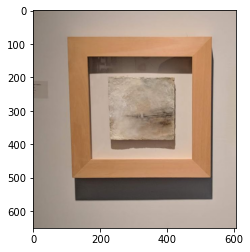

In [5]:
## qsd2-w1 -- Images with background --> we need to crop them
img = readimg ('data/qsd2_w1/00000.jpg')
plt.imshow(img)

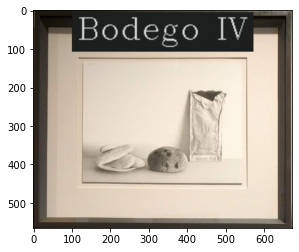

In [6]:
## qsd1-w2 -- cropped images with text
img = readimg ('data/qsd1_w2/00000.jpg')
plt.imshow(img)

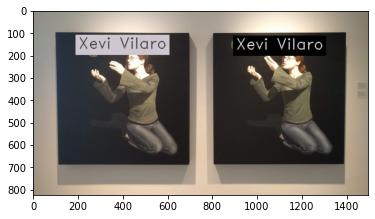

In [7]:
## qsd2-w2 -- multiple pictures per image + background
img = readimg ('data/qsd2_w2/00000.jpg')
plt.imshow(img)

# Task 1

In [8]:
# Load Data
db, db_files = load_data("./data/BBDD/",".jpg", desc = "Loading BBDD Data...")
qsd2_w1, qsd2_w1_files = load_data("./data/qsd2_w1/",".jpg", desc = "Loading qsd2_w1 Data...")

# 3D Normalized Histograms Multiresolutio/Block Images
db_feature_matrix = calculate_histograms(db,16,n_rows=4,n_cols=4,desc="Normalized 3D Histograms Calculation for BBDD...")
qsd2_w1_feature_matrix = calculate_histograms(qsd2_w1,16,n_rows=4,n_cols=4,desc = "Normalized 3D Histograms Calculation for qsd2_w1...")
print(db_feature_matrix.shape)
print(qsd2_w1_feature_matrix.shape)
# Num Images, Num Blocks per Image, N_BINS x N_BINS x N_BINS 3D Histogram
# TODO: concatenate histograms FROM BLOCKS. (287, 16, 16, 16, 16) to (287, 1, 16, 16, 16)

Loading BBDD Data...: 100%|████████████████████████████████████████| 287/287 [00:06<00:00, 43.28it/s]


./data/BBDD/ read: 287 images


Loading qsd2_w1 Data...: 100%|██████████████████████████████████████| 30/30 [00:00<00:00, 142.99it/s]


./data/qsd2_w1/ read: 30 images


Normalized 3D Histograms Calculation for BBDD...: 100%|███████████| 287/287 [00:01<00:00, 183.90it/s]
Normalized 3D Histograms Calculation for qsd2_w1...: 100%|██████████| 30/30 [00:00<00:00, 339.15it/s]

(287, 16, 16, 16, 16)
(30, 16, 16, 16, 16)


(997, 1059, 3) 16 (249, 264, 3)


<Figure size 1080x1080 with 0 Axes>

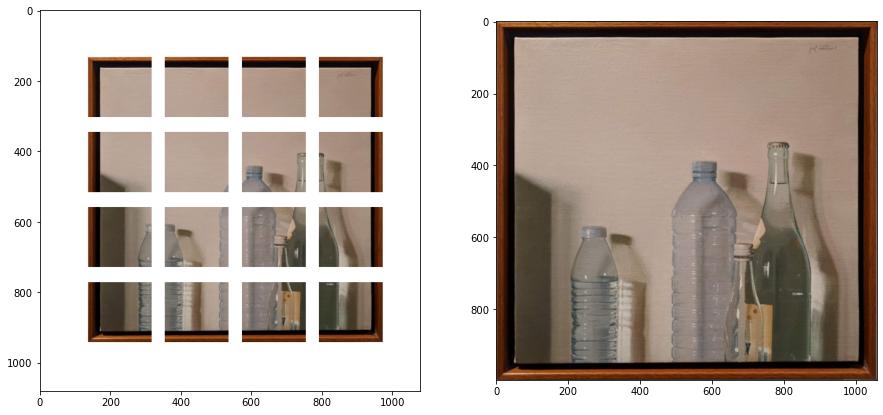

(982, 939, 3) 16 (245, 234, 3)


<Figure size 1080x1080 with 0 Axes>

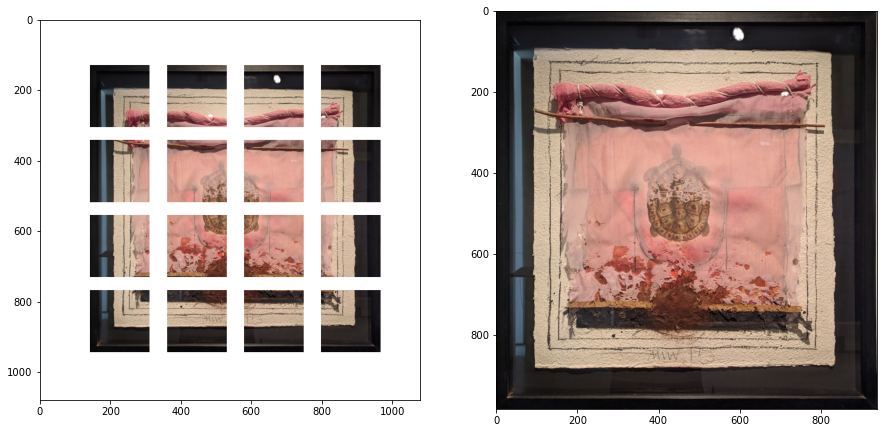

In [9]:
def plot_image_and_windows(images: np.ndarray, n_cols: int, n_rows: int) -> None:
    for im in images:
        windows = image_to_windows(im, n_cols=n_cols, n_rows=n_rows)
        print (im.shape, len(windows), windows[0].shape)
        
        f, axarr = plt.subplots(4,4, figsize=(15,15))
        for i in range(n_rows):
            for j in range(n_cols):
                axarr[i,j].imshow(windows[j+i*n_rows])
                axarr[i,j].axis('off')
                
        plt.savefig('tmp.png')
        plt.clf() 
        f, axarr = plt.subplots(1,2, figsize=(15,15))
        windows = imread('tmp.png')
        axarr[0].imshow(windows)
        axarr[1].imshow(im)
        plt.show()
        os.remove('tmp.png')
        
        
plot_image_and_windows(db[:2], 4, 4)

# Task 6 - Separate

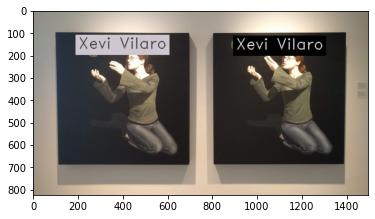

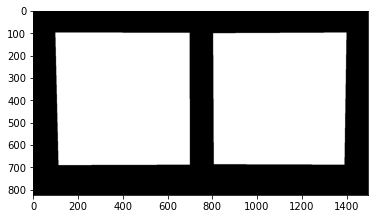

Xevi Vilaro
Xevi Vilaro


In [151]:
## qsd2-w2 -- multiple pictures per image + background
img = readimg ('data/qsd2_w2/00000.jpg')
plt.imshow(img)
plt.show()

img = readimg ('data/qsd2_w2/00000.png')
plt.imshow(img)
plt.show()

!cat 'data/qsd2_w2/00000.txt'

In [152]:
files = sorted(os.listdir('data/qsd2_w2/'))
files = ['data/qsd2_w2/'+x for x in files if '.jpg' in x]
print (len(files))
files[:5]

30


['data/qsd2_w2/00000.jpg',
 'data/qsd2_w2/00001.jpg',
 'data/qsd2_w2/00002.jpg',
 'data/qsd2_w2/00003.jpg',
 'data/qsd2_w2/00004.jpg']

In [153]:
!ls data/qsd2_w2/

00000.jpg  00005.png  00010.txt  00016.jpg  00021.png  00026.txt
00000.png  00005.txt  00011.jpg  00016.png  00021.txt  00027.jpg
00000.txt  00006.jpg  00011.png  00016.txt  00022.jpg  00027.png
00001.jpg  00006.png  00011.txt  00017.jpg  00022.png  00027.txt
00001.png  00006.txt  00012.jpg  00017.png  00022.txt  00028.jpg
00001.txt  00007.jpg  00012.png  00017.txt  00023.jpg  00028.png
00002.jpg  00007.png  00012.txt  00018.jpg  00023.png  00028.txt
00002.png  00007.txt  00013.jpg  00018.png  00023.txt  00029.jpg
00002.txt  00008.jpg  00013.png  00018.txt  00024.jpg  00029.png
00003.jpg  00008.png  00013.txt  00019.jpg  00024.png  00029.txt
00003.png  00008.txt  00014.jpg  00019.png  00024.txt  frames.pkl
00003.txt  00009.jpg  00014.png  00019.txt  00025.jpg  gt_corresps.pkl
00004.jpg  00009.png  00014.txt  00020.jpg  00025.png  text_boxes.pkl
00004.png  00009.txt  00015.jpg  00020.png  00025.txt
00004.txt  00010.jpg  00015.png  00020.txt  00026.jpg
00005.jpg  00010.png  00015.txt  00

In [154]:
with open('data/qsd2_w2/gt_corresps.pkl', 'rb') as f:
    gt_labels = pickle.load(f)

In [155]:
def iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

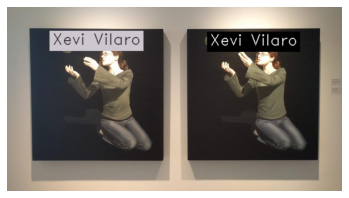

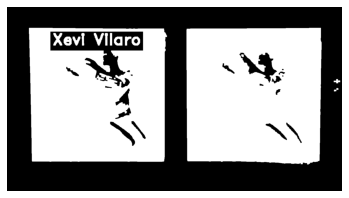

contours detected: 2


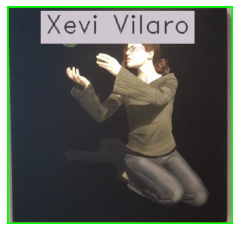

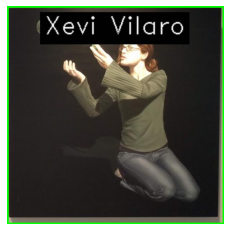

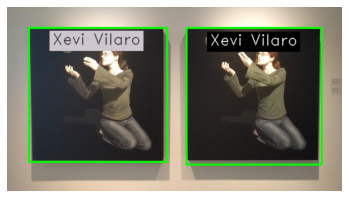

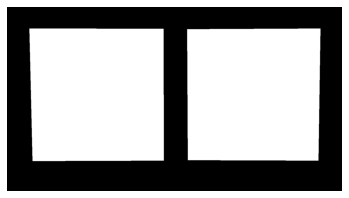

IOU 0.9452476583887102


In [164]:
# Testing method 1

SCORES = []
PREDICTIONS = {}

for file in files:
    
    base = readimg (file)
    gt_mask = readimg (file.replace('.jpg', '.png'))
    
    base_rgb = base.copy()
    base = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
    # Performing OTSU threshold
    ret, base = cv2.threshold(base, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    #base = otsus_binarization(rgb2gray(base))
    
    plt.imshow(base_rgb)
    plt.axis('off')
    plt.show()
    
    #plt.imshow(base, cmap="gray")
    #plt.axis('off')
    #plt.show()
    
    mask = base
    mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10)), iterations = 1)
    mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (8, 8)), iterations = 1)
    mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)), iterations = 1)
    #mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)))
    #mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)))
    
    plt.imshow(mask, cmap="gray")
    plt.axis('off')
    plt.show()
    
    
    # Finding contours
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    boxes = []
    areas = {}
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cropped = base_rgb[y:y + h, x:x + w]
        area_cropped = cropped.shape[0] * cropped.shape[1]
        if (area_cropped <= 200*200) or (cropped.shape[0] < 100) or (cropped.shape[1] < 100): continue
        else: 
            boxes.append((x, y, x + w, y + h))
            areas[area_cropped] = (x, y, x + w, y + h)
            
    print ('contours detected:', len(boxes))
    
    mask = np.zeros(base_rgb.shape)
    
    if len(boxes) > 1:
        # 2 biggest boxes
        
        big = sorted(areas.keys(),reverse=True)
        box1 = areas[big[0]]
        box2 = areas[big[1]]
        nboxes = [box1, box2]
        
        PREDICTIONS[file] = nboxes
        for box in nboxes:
            x, y, x2, y2 = box
            cropped = base_rgb[y:y2, x:x2]
            mask [y:y2, x:x2] = 1
            rect = cv2.rectangle(base_rgb, (x, y), (x2, y2), (0, 255, 0), 8)
            
            plt.imshow(cropped)
            plt.axis('off')
            plt.show()
    else:
        x, y, x2, y2 = boxes[0]
        cropped = base_rgb[y:y2, x:x2]
        mask [y:y2, x:x2] = 1
        print (x, y, x2, y2)
        rect = cv2.rectangle(base_rgb, (x, y), (x2, y2), (0, 255, 0), 8)
        PREDICTIONS[file] = boxes[0]
        plt.imshow(cropped)
        plt.axis('off')
        plt.show()
    
    
    mask = mask.astype(np.uint8) * 255
    
    plt.imshow(base_rgb)
    plt.axis('off')
    plt.show()
    
    #plt.imshow(mask)
    #plt.axis('off')
    #plt.show()
    plt.imshow(gt_mask)
    plt.axis('off')
    plt.show()
    
    try: 
        print ('IOU', iou_score(gt_mask, mask))
        SCORES.append(iou_score(gt_mask, mask))
    except:
        pass
    
    #print (mask.shape,gt_mask.shape, mask.dtype, gt_mask.dtype, gt_mask.max())
    #print ('==========')
    break

In [136]:
len(SCORES), np.mean(SCORES)

(29, 0.7847942024093297)

In [137]:
PREDICTIONS

{'data/qsd2_w2/00000.jpg': [(98, 97, 715, 693), (802, 97, 1406, 705)],
 'data/qsd2_w2/00001.jpg': [(73, 101, 1350, 423), (489, 470, 955, 719)],
 'data/qsd2_w2/00002.jpg': [(712, 0, 1458, 803), (67, 109, 540, 686)],
 'data/qsd2_w2/00003.jpg': (81, 120, 904, 754),
 'data/qsd2_w2/00004.jpg': [(1993, 130, 3460, 2259), (85, 534, 1101, 1862)],
 'data/qsd2_w2/00005.jpg': [(2208, 93, 4025, 2175), (63, 242, 1813, 2051)],
 'data/qsd2_w2/00006.jpg': [(706, 96, 1158, 497), (123, 98, 574, 495)],
 'data/qsd2_w2/00007.jpg': [(112, 110, 755, 748), (635, 486, 902, 841)],
 'data/qsd2_w2/00008.jpg': [(870, 95, 1357, 740), (90, 131, 547, 694)],
 'data/qsd2_w2/00009.jpg': [(630, 78, 1047, 677), (143, 105, 504, 644)],
 'data/qsd2_w2/00010.jpg': (0, 0, 3672, 1885),
 'data/qsd2_w2/00011.jpg': [(110, 61, 551, 549), (626, 159, 875, 432)],
 'data/qsd2_w2/00012.jpg': [(2005, 73, 3817, 1562), (102, 119, 1485, 1538)],
 'data/qsd2_w2/00013.jpg': [(2094, 104, 3786, 2084), (102, 256, 1735, 1953)],
 'data/qsd2_w2/00014

## Task-6 Test

In [165]:
!ls data/qst2_w2

00000.jpg  00004.png  00009.jpg  00013.png  00018.jpg  00022.png  00027.jpg
00000.png  00005.jpg  00009.png  00014.jpg  00018.png  00023.jpg  00027.png
00001.jpg  00005.png  00010.jpg  00014.png  00019.jpg  00023.png  00028.jpg
00001.png  00006.jpg  00010.png  00015.jpg  00019.png  00024.jpg  00028.png
00002.jpg  00006.png  00011.jpg  00015.png  00020.jpg  00024.png  00029.jpg
00002.png  00007.jpg  00011.png  00016.jpg  00020.png  00025.jpg  00029.png
00003.jpg  00007.png  00012.jpg  00016.png  00021.jpg  00025.png
00003.png  00008.jpg  00012.png  00017.jpg  00021.png  00026.jpg
00004.jpg  00008.png  00013.jpg  00017.png  00022.jpg  00026.png


In [166]:
files = sorted(os.listdir('data/qst2_w2/'))
files = ['data/qst2_w2/'+x for x in files if '.jpg' in x]
print (len(files))
files[:5]

30


['data/qst2_w2/00000.jpg',
 'data/qst2_w2/00001.jpg',
 'data/qst2_w2/00002.jpg',
 'data/qst2_w2/00003.jpg',
 'data/qst2_w2/00004.jpg']

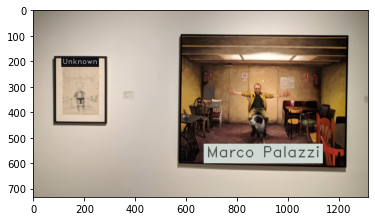

In [167]:
img = readimg (files[0])
plt.imshow(img)
plt.show()

In [168]:
!mkdir w2_masks

mkdir: cannot create directory ‘w2_masks’: File exists


In [169]:
PREDICTIONS = {}

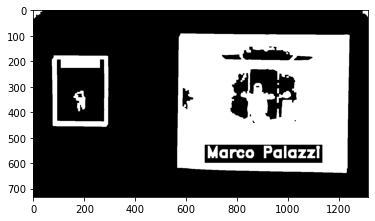

contours detected: 2


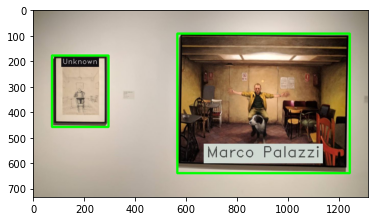

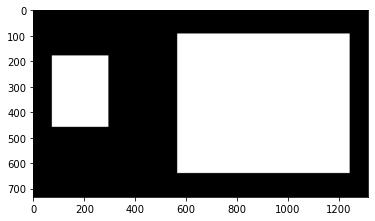

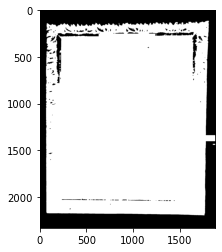

contours detected: 1
64 114 1879 2196


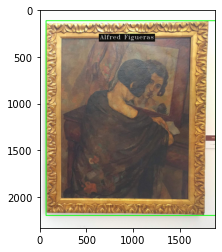

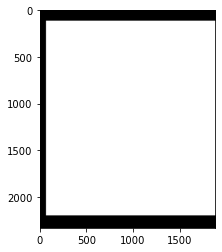

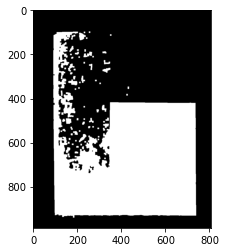

contours detected: 1
92 98 740 941


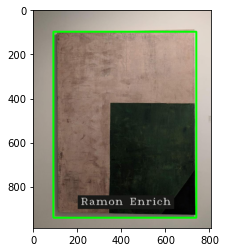

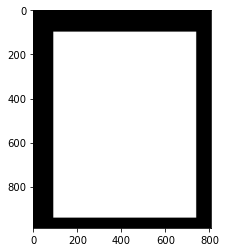

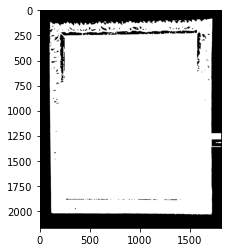

contours detected: 1
94 85 1809 2037


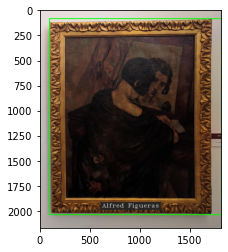

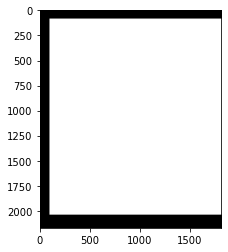

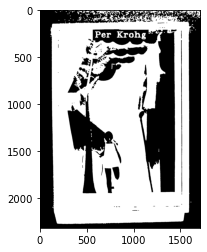

contours detected: 1
109 0 1613 2276


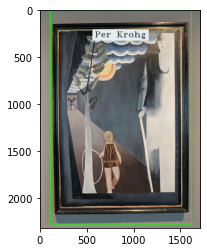

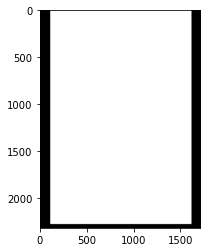

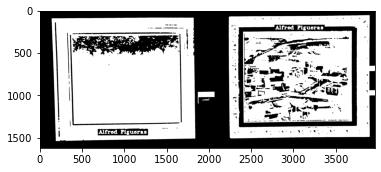

contours detected: 2


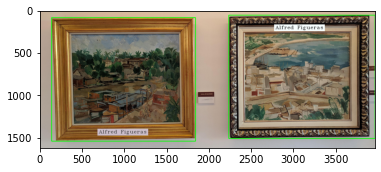

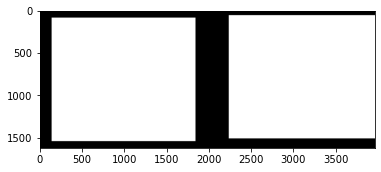

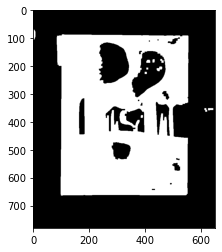

contours detected: 1
85 87 557 664


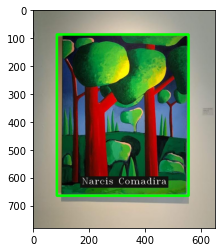

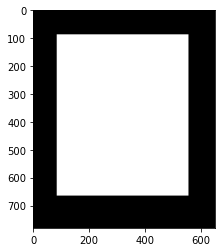

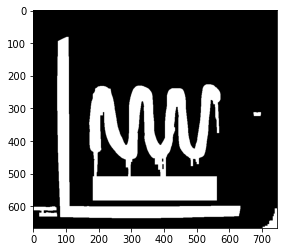

contours detected: 2


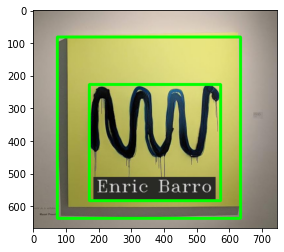

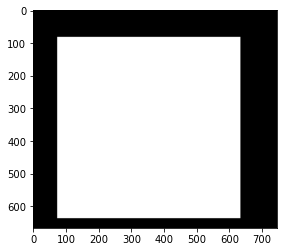

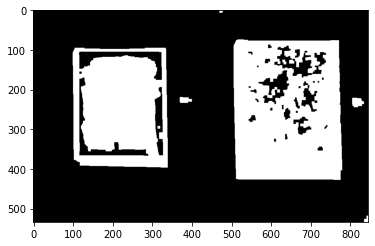

contours detected: 2


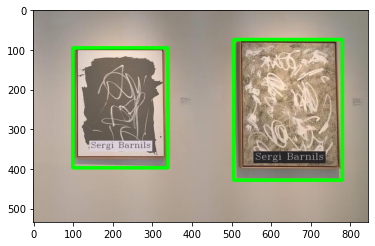

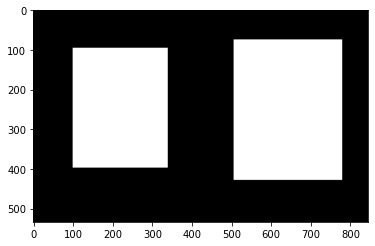

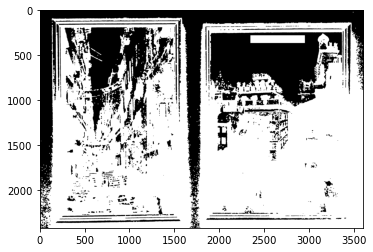

contours detected: 1
0 82 3602 2424


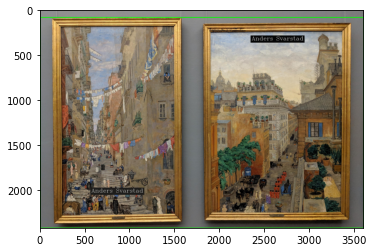

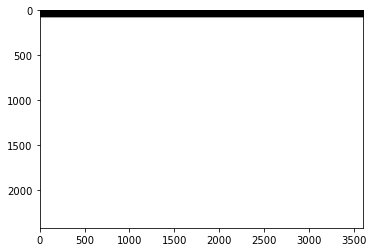

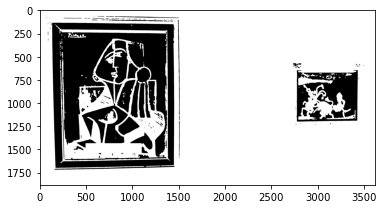

contours detected: 1
0 0 3613 1883


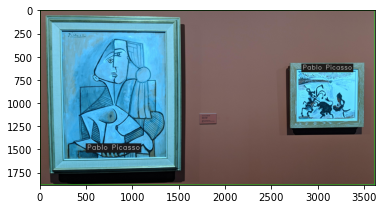

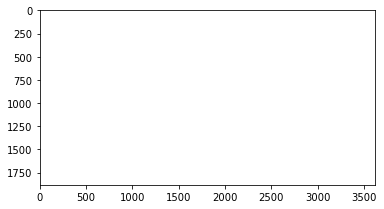

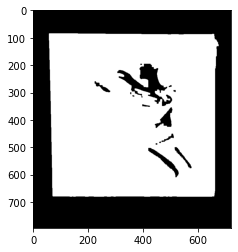

contours detected: 1
58 85 678 681


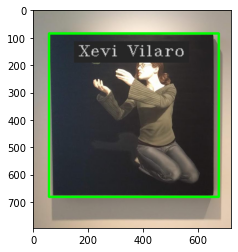

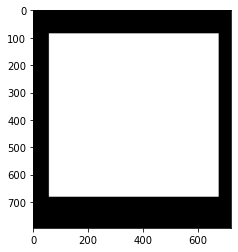

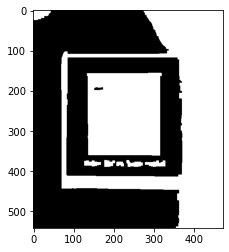

contours detected: 1
70 0 472 542


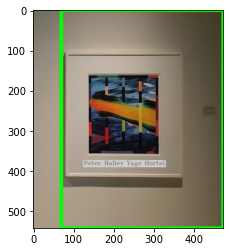

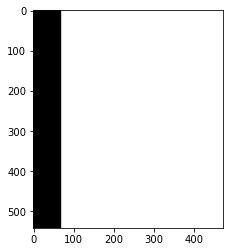

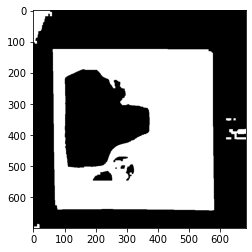

contours detected: 1
63 125 581 643


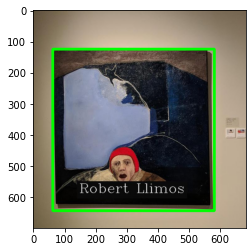

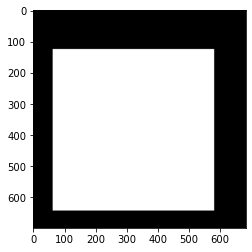

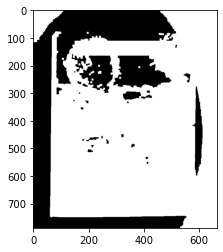

contours detected: 1
61 0 664 788


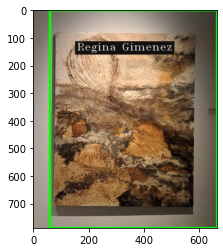

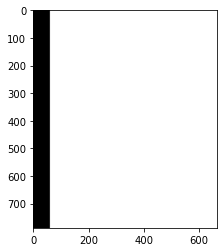

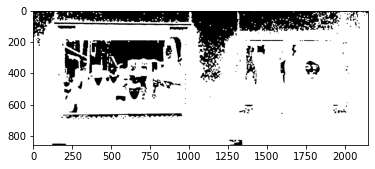

contours detected: 1
0 0 2150 859


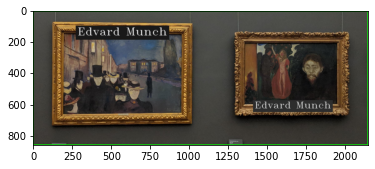

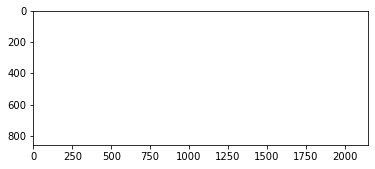

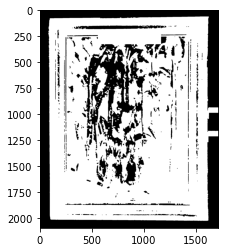

contours detected: 1
80 62 1715 2022


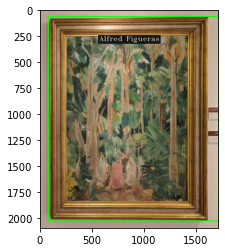

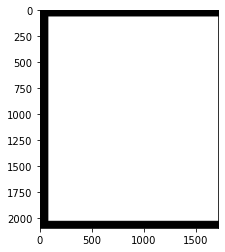

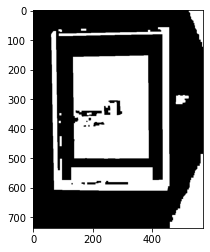

contours detected: 2


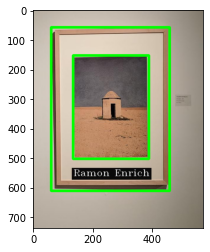

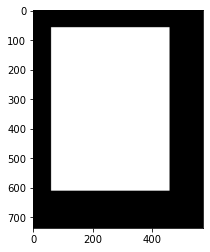

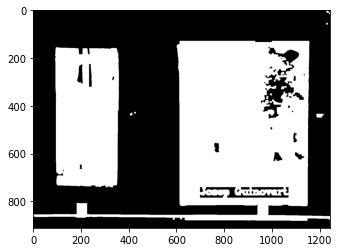

contours detected: 2


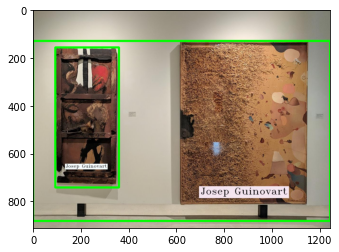

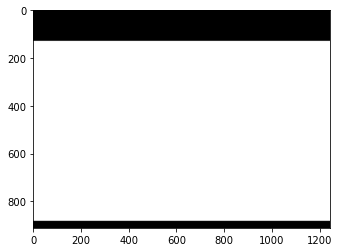

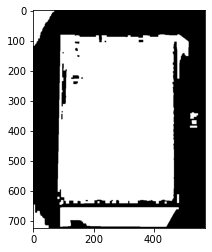

contours detected: 1
82 81 517 643


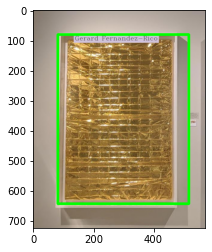

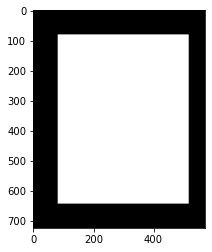

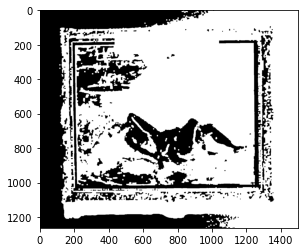

contours detected: 1
115 0 1501 1263


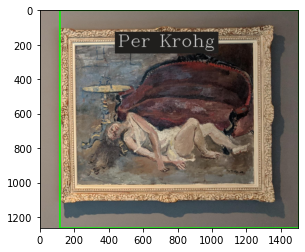

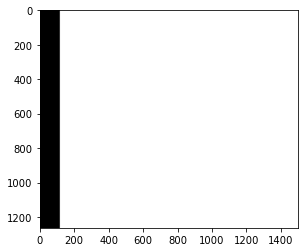

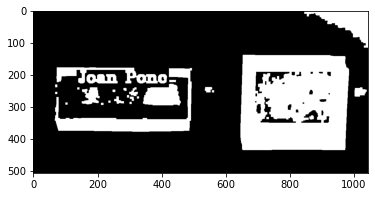

contours detected: 2


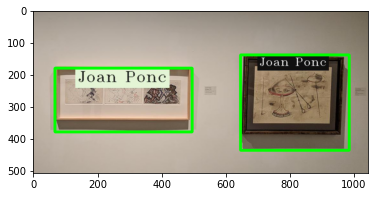

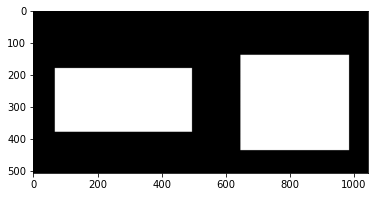

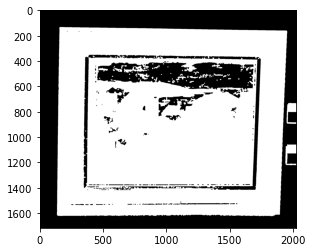

contours detected: 1
133 134 1945 1623


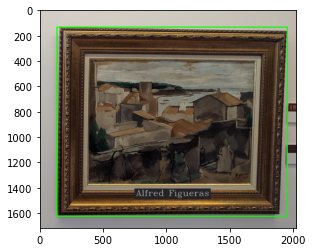

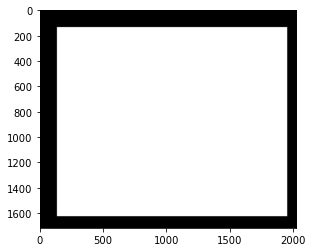

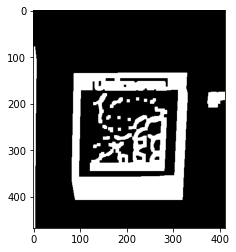

contours detected: 1
83 134 332 407


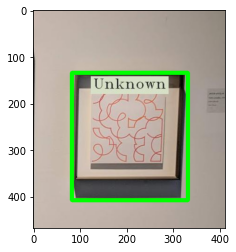

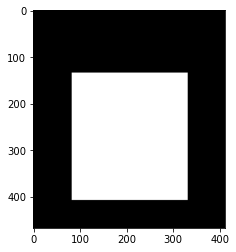

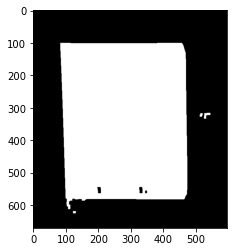

contours detected: 1
84 101 475 612


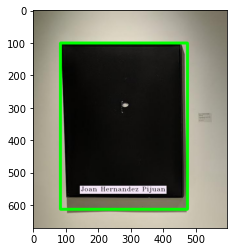

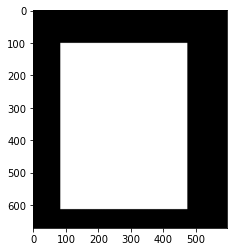

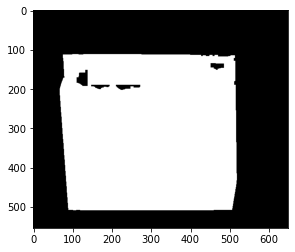

contours detected: 1
68 112 519 509


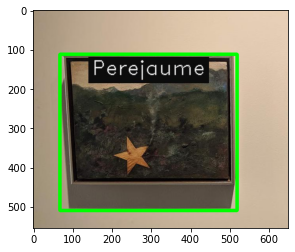

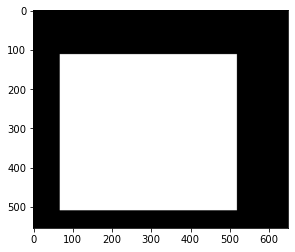

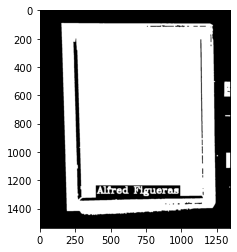

contours detected: 1
150 91 1236 1445


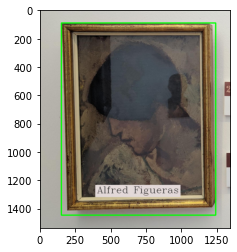

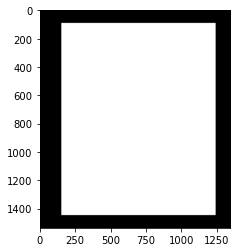

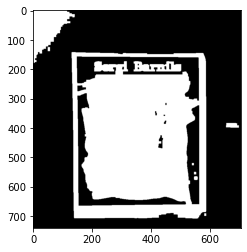

contours detected: 1
131 143 589 709


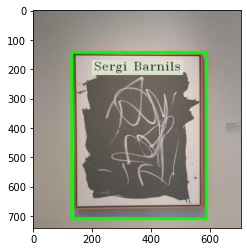

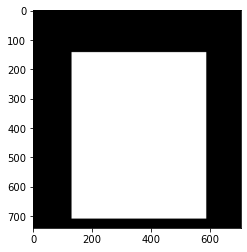

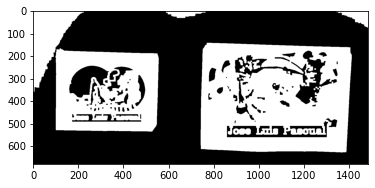

contours detected: 3


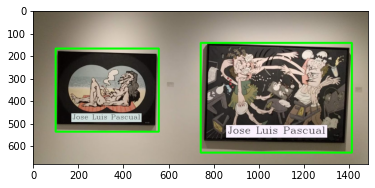

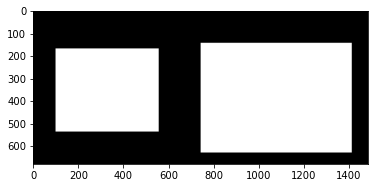

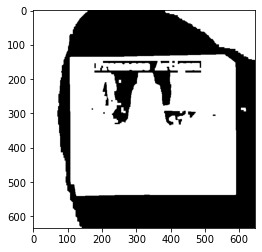

contours detected: 2


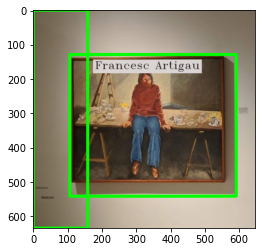

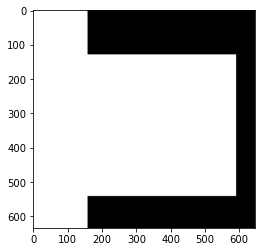

In [170]:
# Testing method 1

SCORES = []

for file in files:
    
    base = readimg (file)

    base_rgb = base.copy()
    base = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
    # Performing OTSU threshold
    ret, base = cv2.threshold(base, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    #base = otsus_binarization(rgb2gray(base))
    
    #plt.imshow(base_rgb)
    #plt.show()
    
    mask = base
    mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10)), iterations = 1)
    mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (8, 8)), iterations = 1)
    mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)), iterations = 1)
    #mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)))
    #mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)))
    
    plt.imshow(mask, cmap="gray")
    plt.show()
    
    
    # Finding contours
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    boxes = []
    areas = {}
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cropped = base_rgb[y:y + h, x:x + w]
        area_cropped = cropped.shape[0] * cropped.shape[1]
        if (area_cropped <= 200*200) or (cropped.shape[0] < 100) or (cropped.shape[1] < 100): continue
        else: 
            boxes.append((x, y, x + w, y + h))
            areas[area_cropped] = (x, y, x + w, y + h)
            
    print ('contours detected:', len(boxes))
    
    mask = np.zeros(base_rgb.shape)
    
    if len(boxes) > 1:
        # 2 biggest boxes
        
        big = sorted(areas.keys(),reverse=True)
        box1 = areas[big[0]]
        box2 = areas[big[1]]
        nboxes = [box1, box2]
        PREDICTIONS[file] = nboxes
        for box in nboxes:
            x, y, x2, y2 = box
            cropped = base_rgb[y:y2, x:x2]
            mask [y:y2, x:x2] = 1
            rect = cv2.rectangle(base_rgb, (x, y), (x2, y2), (0, 255, 0), 8)
    else:
        x, y, x2, y2 = boxes[0]
        cropped = base_rgb[y:y2, x:x2]
        mask [y:y2, x:x2] = 1
        print (x, y, x2, y2)
        rect = cv2.rectangle(base_rgb, (x, y), (x2, y2), (0, 255, 0), 8)
        PREDICTIONS[file] = boxes[0]
    
    
    mask = mask.astype(np.uint8) * 255
    
    plt.imshow(base_rgb)
    plt.show()
    
    plt.imshow(mask)
    plt.show()
    
    #print (file.replace('.jpg', '.png').replace('data/qst2_w2/', 'w2_masks/'))
    cv2.imwrite(file.replace('.jpg', '.png').replace('data/qst2_w2/', 'w2_masks/'), mask)


In [149]:
!ls w2_masks/

00000.png  00005.png  00010.png  00015.png  00020.png  00025.png
00001.png  00006.png  00011.png  00016.png  00021.png  00026.png
00002.png  00007.png  00012.png  00017.png  00022.png  00027.png
00003.png  00008.png  00013.png  00018.png  00023.png  00028.png
00004.png  00009.png  00014.png  00019.png  00024.png  00029.png


In [150]:
PREDICTIONS

{'data/qst2_w2/00000.jpg': [(566, 92, 1243, 639), (74, 178, 296, 458)],
 'data/qst2_w2/00001.jpg': (64, 114, 1879, 2196),
 'data/qst2_w2/00002.jpg': (92, 98, 740, 941),
 'data/qst2_w2/00003.jpg': (94, 85, 1809, 2037),
 'data/qst2_w2/00004.jpg': (109, 0, 1613, 2276),
 'data/qst2_w2/00005.jpg': [(2231, 60, 3960, 1509), (137, 89, 1838, 1541)],
 'data/qst2_w2/00006.jpg': (85, 87, 557, 664),
 'data/qst2_w2/00007.jpg': [(74, 82, 635, 636), (172, 227, 574, 582)],
 'data/qst2_w2/00008.jpg': [(506, 74, 780, 428), (100, 95, 340, 397)],
 'data/qst2_w2/00009.jpg': (0, 82, 3602, 2424),
 'data/qst2_w2/00010.jpg': (0, 0, 3613, 1883),
 'data/qst2_w2/00011.jpg': (58, 85, 678, 681),
 'data/qst2_w2/00012.jpg': (70, 0, 472, 542),
 'data/qst2_w2/00013.jpg': (63, 125, 581, 643),
 'data/qst2_w2/00014.jpg': (61, 0, 664, 788),
 'data/qst2_w2/00015.jpg': (0, 0, 2150, 859),
 'data/qst2_w2/00016.jpg': (80, 62, 1715, 2022),
 'data/qst2_w2/00017.jpg': [(61, 58, 461, 610), (135, 153, 391, 502)],
 'data/qst2_w2/00018